In [6]:
### Bottomonium ERT implementation

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.linalg import expm
from scipy.linalg import block_diag
from scipy.sparse import diags
from scipy.interpolate import interp1d
from scipy.integrate import quad
from math import factorial

In [7]:
def dag(array):
    return array.T.conj()

In [8]:
class ERTens: #AkL list of dissapators w/ sqrt(Γ) inc. that are functions of (t)
    def __init__(self, H, AkL, dt, psiI, R=None, init_t=None):
        self.H = H #Hamiltonian
        self.AkL = AkL #Dissipators
        self.K = len(AkL) 
        self.dt = dt #Explicit time step
        self.psiL = np.array([psiI])
        self.R = np.power(2*len(AkL),2) if R==None else R #Truncation size
        self.t = 0.0 if init_t==None else init_t
    def Jk(self, A):
        #print(self.H.shape)
        return (-1j*self.H)+((self.K/2)*((A@A)-(dag(A)@A)))
    def Uk(self, A):
        return expm((self.dt*self.Jk(A))-(1j*np.sqrt(self.K*self.dt)*A))
    def Vk(self, A):
        return expm((self.dt*self.Jk(A))+(1j*np.sqrt(self.K*self.dt)*A))
    def step(self):
        nPsi = []
        for A in self.AkL:
            for psi in self.psiL:
                nPsi.append(self.Uk(A(self.t))@psi)
                nPsi.append(self.Vk(A(self.t))@psi)
        nPsi = np.array(nPsi)
        Sij = np.dot(nPsi.conj(),nPsi.T)
        w, Uuns = np.linalg.eigh(Sij)
        idx = np.argsort(w)[::-1]
        Ulk = Uuns[:,idx]
        if len(nPsi) > self.R:
            UR = Ulk.T.conj()[:self.R]/np.sqrt(2*self.K)
        else:
            UR = Ulk.T.conj()
        rPsi = UR@nPsi
        self.psiL = rPsi
        self.t += self.dt
    def obs(self, O):
        return np.mean(np.array([psi.conj()@O@psi for psi in self.psiL]))
    def tick(self, O):
        self.step()
        return self.obs(O)

C:\Users\Jacob\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


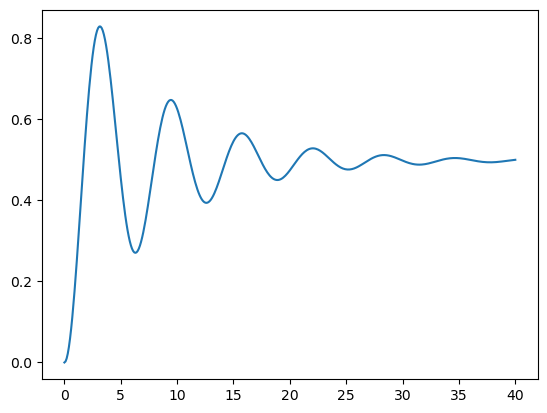

In [9]:
# Optical Bloch Test

Sx = np.array([[0,1],[1,0]])
Sp = np.array([[0,1],[0,0]])
Sm = dag(Sp)
Es = np.array([1,0])
Gs = np.array([0,1])
I2 = np.array([[1,0],[0,1]])

pE = np.array([[1,0],[0,0]])

Om = 1 # This makes it such that t = t*Om
Δ = 0
Γ = Om/6
g=np.sqrt(Γ)

Hopt = -((Om/2)*Sx)-(Δ*(Sp@Sm))
Heff = Hopt - ((1j*Γ/2)*(Sp@Sm))

Aobe = lambda t: Sm*g

OBT = ERTens(Hopt, [Aobe], 0.1, Gs)
Ndt = 400
res = np.array([OBT.tick(pE) for i in range(400)])
res = np.insert(res, 0, Gs@pE@Gs)
plt.plot(np.linspace(0,40,401), res)
plt.show()



In [11]:
# Bottomonium system [GeV]

TBjorkenData = np.array([
    (0.6, 0.425),(0.65, 0.4138),(0.7, 0.4037),(0.75, 0.3945),(0.8, 0.3861),(0.85, 0.3784),(0.9, 0.3713),(0.95, 0.3646),
    (1.0, 0.3585),(1.05, 0.3527),(1.1, 0.3472),(1.15, 0.3421),(1.2, 0.3373),(1.25, 0.3328),(1.3, 0.3284),(1.35, 0.3243),(1.4, 0.3204),(1.45, 0.3167),
    (1.5, 0.3131),(1.55, 0.3097),(1.6, 0.3065),(1.65, 0.3034),(1.7, 0.3003),(1.75, 0.2975),(1.8, 0.2947),(1.85, 0.2920),(1.9, 0.2894),(1.95, 0.2869),
    (2.0, 0.2845),(2.05, 0.2822),(2.1, 0.2799),(2.15, 0.2777),(2.2, 0.2756),(2.25, 0.2736),(2.3, 0.2716),(2.35, 0.2696),(2.4, 0.2677),(2.45, 0.2659),
    (2.5, 0.2641),(2.55, 0.2624),(2.6, 0.2607),(2.65, 0.2590),(2.7, 0.2574),(2.75, 0.2559),(2.8, 0.2543),(2.85, 0.2528),(2.9, 0.2514),(2.95, 0.2499),
    (3.0, 0.2485),(3.05, 0.2472),(3.1, 0.2458),(3.15, 0.2445),(3.2, 0.2433),(3.25, 0.2420),(3.3, 0.2408),(3.35, 0.2396),(3.4, 0.2384),(3.45, 0.2372),
    (3.5, 0.2361),(3.55, 0.2350),(3.6, 0.2339),(3.65, 0.2328),(3.7, 0.2318),(3.75, 0.2307),(3.8, 0.2297),(3.85, 0.2287),(3.9, 0.2277),(3.95, 0.2268),
    (4.0, 0.2258),(4.05, 0.2249),(4.1, 0.2240),(4.15, 0.2231),(4.2, 0.2222),(4.25, 0.2213),(4.3, 0.2204),(4.35, 0.2196),(4.4, 0.2188),(4.45, 0.2179),
    (4.5, 0.2171),(4.55, 0.2163),(4.6, 0.2155),(4.65, 0.2148),(4.7, 0.2140),(4.75, 0.2132),(4.8, 0.2125),(4.85, 0.2118),(4.9, 0.2110),(4.95, 0.2103),
    (5.0, 0.2096),(5.05, 0.2089),(5.1, 0.2082),(5.15, 0.2075),(5.2, 0.2069),(5.25, 0.2062),(5.3, 0.2055),(5.35, 0.2049),(5.4, 0.2043),(5.45, 0.2036),
    (5.5, 0.2030),(5.55, 0.2024),(5.6, 0.2018),(5.65, 0.2012),(5.7, 0.2006),(5.75, 0.2000),(5.8, 0.1994),(5.85, 0.1989),(5.9, 0.1983),(5.95, 0.1977),
    (6.0, 0.1972),(6.05, 0.1966),(6.1, 0.1960),(6.15, 0.1955),(6.2, 0.1949),(6.25, 0.1944),(6.3, 0.1938),(6.35, 0.1933),(6.4, 0.1927),(6.45, 0.1922),
    (6.5, 0.1917),(6.55, 0.1911),(6.6, 0.1906),(6.65, 0.1901),(6.7, 0.1896),(6.75, 0.1891),(6.8, 0.1885),(6.85, 0.1880),(6.9, 0.1875),(6.95, 0.1870),
    (7.0, 0.1865),(7.05, 0.1860),(7.1, 0.1855),(7.15, 0.1850),(7.2, 0.1845),(7.25, 0.1840),(7.3, 0.1835),(7.35, 0.1830),(7.4, 0.1825),(7.45, 0.1820),
    (7.5, 0.1815),(7.55, 0.1810),(7.6, 0.1805),(7.65, 0.1800),(7.7, 0.1795),(7.75, 0.1790),(7.8, 0.1785),(7.85, 0.1780),(7.9, 0.1775),(7.95, 0.1770),
    (8.0, 0.1765),(8.05, 0.1760),(8.1, 0.1755),(8.15, 0.1750),(8.2, 0.1745),(8.25, 0.1740),(8.3, 0.1735),(8.35, 0.1730),(8.4, 0.1725),(8.45, 0.1720),
    (8.5, 0.1715),(8.55, 0.1710),(8.6, 0.1705),(8.65, 0.1700),(8.7, 0.1695),(8.75, 0.1690),(8.8, 0.1685),(8.85, 0.1680),(8.9, 0.1675),(8.95, 0.1670),
    (9.0, 0.1665),(9.05, 0.1660),(9.1, 0.1655),(9.15, 0.1650),(9.2, 0.1645),(9.25, 0.1640),(9.3, 0.1635),(9.35, 0.1630),(9.4, 0.1625),(9.45, 0.1620),
    (9.5, 0.1615),(9.55, 0.1610),(9.6, 0.1605),(9.65, 0.1600),(9.7, 0.1595),(9.75, 0.1590),(9.8, 0.1585),(9.85, 0.1580),(9.9, 0.1575),(9.95, 0.1570),
    (10.0, 0.1500)
])
TBjorken = interp1d(TBjorkenData[:,0],TBjorkenData[:,1],kind='cubic')

NPts = 2048
RMax = 40 # [GeV]

kSet = 0
Tc = 0.155 # [GeV]
hbarc = 0.1973

m = 4.73 # [GeV] bottom quark mass
aS = 0.3 # alphaS
α = ((4*aS)/3)

gam = -1.75
def k(T):
    Ts = T/Tc
    if kSet == 0:
        return 1/(0.00397*np.power(Ts, 3/2) - 0.08341*Ts + 0.98031*np.power(Ts, 1/2) - 0.51889)
    
##### Potentials

### Munich Potential
# Real
def VsR(r,T):
    return -(α/r) + ((1/2)*gam*np.power(T,3)*np.power(r,2))
def VoR(r,T):
    return -((1/8)*(α/r)) + ((7/32)*gam*np.power(T,3)*np.power(r,2))
# Imaginary
def VsI(r,T):
    return -(1/2)*k(T)*np.power(T,3)*np.power(r,2)
def VoI(r,T):
    return -(7/32)*k(T)*np.power(T,3)*np.power(r,2)

### KSU Isotropic
NF = 2
NC = 3
Fmd = 1
alpha = 0.6239853 # alphaS *(4/3)
a_EC = 0.409 # effective coupling
sigma = 0.21 # [GeV^2] string tension

### Phi function


def T2expO(N): # returns function expansion of T2 with n terms aprox O(2n)
    return lambda r, z: sum((-1)**k * np.power(z*r,2*k) / factorial(2*k+1) for k in range(N)) 
def T2expOsx(N): # returns function expansion of T2 with n terms aprox O(2n) small x
    return lambda r, z: sum((-1)**k * np.power(z*r,2*k) / factorial(2*k+1) for k in range(N)) 
def T2expOLx(N): # returns function expansion of T2 with n terms aprox O(2n) large x
    return lambda r, z: sum(
        (-1)**k * (np.cos(z*r) / (z*r)**(2*k+1) if k % 2 == 0 else np.sin(z*r) / (z*r)**(2*k+1)) for k in range(N)) 

def intPhi(N):
    zMax = 10
    rT = np.linspace(0.01,RMax,80)
    res = []
    for ri in rT:
        integrand = lambda z: (z/(((z**2)+1)**2)) * (1-T2expO(2*N+1)(ri,z))
        #print(integrand(1))
        #print('int: ',ri)
        integral_result, _ = quad(integrand, 0.1, zMax)
        res.append([ri,2*integral_result])
    return np.array(res)

def intPhi2(N):
    zMax = 10
    rT = np.linspace(0.01,RMax,200)
    swPt = 1
    res = []
    for ri in rT:
        integrand = lambda z: np.piecewise(z,[z*ri<swPt,z*ri>=swPt],  
                                           [(z/(((z**2)+1)**2)) * (1-T2expOsx(N)(ri,z)),
                                           (z/(((z**2)+1)**2)) * (1-T2expOLx(N)(ri,z))]
                                          )
        #print(integrand(1))
        #print('int: ',ri)
        integral_result, _ = quad(integrand, 0.1, zMax)
        res.append([ri,2*integral_result])
    return np.array(res) #function of rhat

#phiDat = intPhi2(40)
#phiInt = interp1d(phiDat[:,0],phiDat[:,1],kind='cubic')


# 3-loop (stolen)
def alphaS(T):
    #return (2*np.power(B0,6)*np.power(t,3) - 6*B0*B1*B2*np.log(t) - 2*np.power(B0,4)*B1*np.power(t,2)*np.log(t) - np.power(B1,3)*((1-4*log(t)-5*np.power(np.log(t),2))+2*np.power(np.log(t),3))  )
    mu = 2*np.pi*T
    t = 2*np.log(mu/LAMBDA_MS);
    return (2*B0*B0*B0*B0*B0*B0*t*t*t - 6*B0*B1*B2*np.log(t) - 2*B0*B0*B0*B0*B1*t*t*np.log(t) - B1*B1*B1*(1-4*np.log(t)-5*np.log(t)*np.log(t)+2*np.log(t)*np.log(t)*np.log(t)) + 2*B0*B0*t*(B0*B2 - B1*B1*(1+np.log(t)-np.log(t)*np.log(t))))/(2*B0*B0*B0*B0*B0*B0*B0*t*t*t*t)


def mD(T):
    return Fmd*T*np.sqrt(NC*(1+(NF/6))*np.pi*alpha)
rsb = 1.25/hbarc # 1.25 fm
# Real
def Vvac(r):
    return np.piecewise(r,
                       [r<=rsb, r>rsb],
                       [-(a_EC/r)+(sigma*r), -(a_EC/rsb)+(sigma*rsb)])
def VisoKMS(r,T):
    mD_r = mD(T)*r
    return -(a_EC/r)*(1+(mD_r))*np.exp(-mD_r) + ((2*sigma/mD(T))*(1-np.exp(-mD_r))) - (sigma*r*np.exp(-mD_r))
def VisoR(r,T):
    return np.where(VisoKMS(r,T) <= Vvac(r), VisoKMS(r,T), Vvac(r))

# Imaginary

def VisoI(r,T):
    return 0

# Phi function


def VsI_KSUI(r,T):
    return -(1/2)*k(T)*np.power(T,3)*np.power(r,2)
    
    
### Single blocks

# position operator (partial - one block) 
rv = np.linspace(0.01, RMax, NPts)
rs = np.diag(rv)
ris = np.diag(1/rv)
dr = rv[1]-rv[0]

# Central difference
ps = -1j*(((np.diag(np.ones(NPts-1),1)-np.diag(np.ones(NPts-1),-1))/(2*dr)) + ris)
ps = -1j*(np.diag(np.ones(NPts-1),1)-np.diag(np.ones(NPts-1),-1))/(2*dr)
# Forward difference
# Backward difference


#Kinetic Energy operator
Tkin = np.diag(np.full(NPts, -2.0)) + np.diag(np.full(NPts-1, 1.0), k=1) + np.diag(np.full(NPts-1, 1.0), k=-1)
Tkin *= -1 / (2*m * dr**2)

#Potential Operator
def Vs(r,T):
    return np.diag(VsR(r,T) + 1j*VsI(r,T))
def Vo(r,T):
    return np.diag(VoR(r,T) + 1j*VoI(r,T))

def Hs(T):
    return Tkin+Vs(rv,T)
def Ho(T):
    return Tkin+Vo(rv,T)

### [s,o] Blocks

def Hbot(T):
    return np.block([[Hs(T),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),Ho(T)]])

#Hbot = np.block([[hs+((1/2)*gam*r2s),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),ho+((7/32)*gam*r2s)]])


C0con = np.block([[np.zeros((NPts, NPts)),np.eye(NPts)],[np.eye(NPts)*np.sqrt(8),np.zeros((NPts, NPts))]])
C1con = np.block([[np.zeros((NPts, NPts)),np.zeros((NPts, NPts))],[np.zeros((NPts, NPts)),np.eye(NPts)]])
def genC(so,ri): #so-upper index ri-lower index(corresponds to different spatial directions r_i)
    if 0 == so:
        return lambda t: np.sqrt(k(TBjorken(t).item())/8)*C0con #Nc=3 => Nc^2 - 1 = 8
    if 1 == so:
        return lambda t: np.sqrt(5*k(TBjorken(t).item())/16)*C1con #Nc=3 => (Nc^2-4)/(2(Nc^2-1)) = 5/16

In [12]:
B0=(11*NC-2*NF)/(12*np.pi)
B1=(17*NC*NC-NF*(10*NC+6*(NC*NC-1)/(2*NC))/2)/(24*np.pi*np.pi)
B2=(2857 - 5033*NF/9 + 325*NF*NF/27)/(128*np.pi*np.pi*np.pi)       

In [46]:
print('B0: ',B0)
print('B1: ',B1)
print('B2: ',B2)

B0:  0.7692488916108274
B1:  0.48549733828620184
B2:  0.45018700017128954


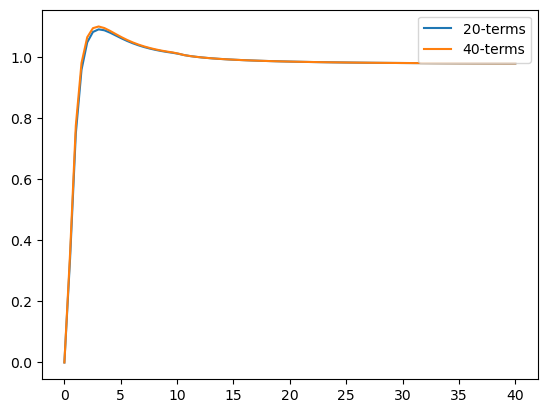

In [42]:
#pI10 = intPhi2(10)
pI20 = intPhi2(20)
#pI30 = intPhi2(30)
pI40 = intPhi2(40)

#plt.plot(pI10[:,0],pI10[:,1],label="10-terms")
plt.plot(pI20[:,0],pI20[:,1],label="20-terms")
#plt.plot(pI30[:,0],pI30[:,1],label="30-terms")
plt.plot(pI40[:,0],pI40[:,1],label="40-terms")


plt.legend()
plt.show()

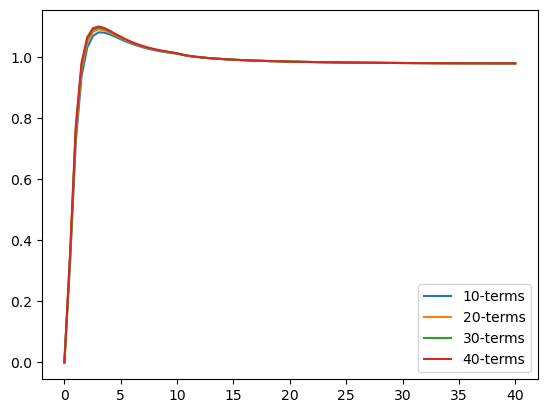

In [43]:
plt.plot(pI10[:,0],pI10[:,1],label="10-terms")
plt.plot(pI20[:,0],pI20[:,1],label="20-terms")
plt.plot(pI30[:,0],pI30[:,1],label="30-terms")
plt.plot(pI40[:,0],pI40[:,1],label="40-terms")



plt.legend()
plt.show()

(2048,)
(2048,)
(2048,)
(2048,)
(2048,)
(2048,)


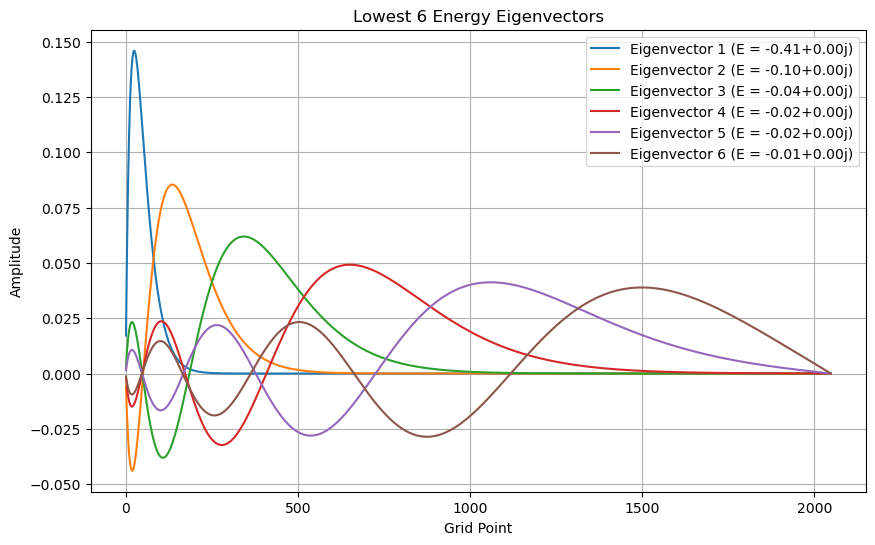

In [10]:

eigenvalues, eigenvectors = np.linalg.eig(Hs(0))
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]
# Plot the six lowest energy eigenvectors
plt.figure(figsize=(10, 6))
for i in range(6):
    print(eigenvectors[:, i].shape)
    plt.plot(eigenvectors[:, i], label=f"Eigenvector {i+1} (E = {eigenvalues[i]:.2f})")

plt.title("Lowest 6 Energy Eigenvectors")
plt.xlabel("Grid Point")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
intPhi(5)

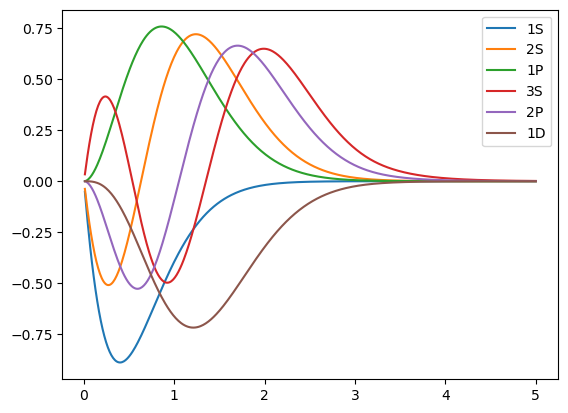

In [54]:
basisStRaw = np.loadtxt('./basisStates.tsv', delimiter='\t')[:,0]
bStPart = np.array_split(basisStRaw,6)
vCut = int(4096/8)
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[0][:vCut],label='1S')
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[1][:vCut],label='2S')
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[2][:vCut],label='1P')
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[3][:vCut],label='3S')
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[4][:vCut],label='2P')
plt.plot(np.linspace(0.01,40,4096)[:vCut], bStPart[5][:vCut],label='1D')
plt.legend()
plt.show()

#BasisStateInterpolating functions
intF1S = interp1d(np.linspace(0.01,40,4096),bStPart[0],kind='cubic')
intF2S = interp1d(np.linspace(0.01,40,4096),bStPart[1],kind='cubic')
intF1P = interp1d(np.linspace(0.01,40,4096),bStPart[2],kind='cubic')
intF3S = interp1d(np.linspace(0.01,40,4096),bStPart[3],kind='cubic')
intF2P = interp1d(np.linspace(0.01,40,4096),bStPart[4],kind='cubic')
intF1D = interp1d(np.linspace(0.01,40,4096),bStPart[5],kind='cubic')

### Basis States in so format

BS1S = np.concatenate([intF1S(rv), np.zeros(NPts)])
BS2S = np.concatenate([intF2S(rv), np.zeros(NPts)])
BS1P = np.concatenate([np.zeros(NPts), intF1P(rv)])
BS3S = np.concatenate([intF3S(rv), np.zeros(NPts)])
BS2P = np.concatenate([np.zeros(NPts), intF2P(rv)])
BS1D = np.concatenate([np.zeros(NPts), intF1D(rv)])

In [12]:
AL = [genC(0,0),genC(0,1),genC(0,2),genC(1,0),genC(1,1),genC(1,2)]
botEns = ERTens(Hbot, AL, 0.01, BS1S , init_t=0.6)
resB = np.array([botEns.tick(diags(BS1S, offsets=0, format='csr')) for i in range(100)])

TypeError: unsupported operand type(s) for *: 'complex' and 'function'

In [ ]:
Hbot(0)

In [ ]:
np.array_split(basisStRaw,6)

In [ ]:
np.diag(np.ones(NPts-1),1)

In [ ]:
-np.diag(np.ones(NPts-1),-1)

In [ ]:
ris

In [ ]:
import numpy as np

# Define the blocks (A, B, C)
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8]])
C = np.array([[9, 10], [11, 12]])

# Construct the block diagonal matrix using numpy.block
block_diag_matrix = np.block([[A, np.zeros_like(A), np.zeros_like(A)],
                              [np.zeros_like(B), B, np.zeros_like(B)],
                              [np.zeros_like(C), np.zeros_like(C), C]])

print(block_diag_matrix.shape)


In [ ]:
np.block([[hs+((1/2)*gam*r2s),np.zeros((NPts,NPts))],[np.zeros((NPts,NPts)),ho+((7/32)*gam*r2s)]])

In [ ]:
type(ps)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
N = 1000  # Number of grid points
x_min, x_max = 0.1, 20.0  # Radial grid (avoid r = 0 to prevent division by zero)
x = np.linspace(x_min, x_max, N)
dx = x[1] - x[0]  # Grid spacing
hbar = 1.0  # Reduced Planck's constant
mass = 1.0  # Quark mass (in arbitrary units)

# Munich potential parameters
alpha = 1.0  # Coulomb-like strength
sigma = 0.1  # String tension

# Munich potential: V(r) = -alpha/r + sigma * r
V = -alpha / x + sigma * x

# Kinetic energy operator (finite difference for the second derivative)
T = np.diag(np.full(N, -2.0)) + np.diag(np.full(N-1, 1.0), k=1) + np.diag(np.full(N-1, 1.0), k=-1)
T *= -hbar**2 / (2 * mass * dx**2)

# Hamiltonian: H = T + V
H = T + np.diag(V)  # Potential is diagonal in the radial grid

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(H)

# Sort eigenvalues and eigenvectors by ascending energy
idx = np.argsort(eigenvalues)
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Plot the first 6 eigenfunctions (real part)
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(x, eigenvectors[:, i], label=f"Eigenfunction {i+1} (E = {eigenvalues[i]:.2f})")

plt.title("Lowest 6 Energy Eigenfunctions for Munich Potential")
plt.xlabel("Radial Distance (r)")
plt.ylabel("Wavefunction Amplitude")
plt.legend()
plt.grid(True)
plt.show()
()


In [ ]:

Tkin

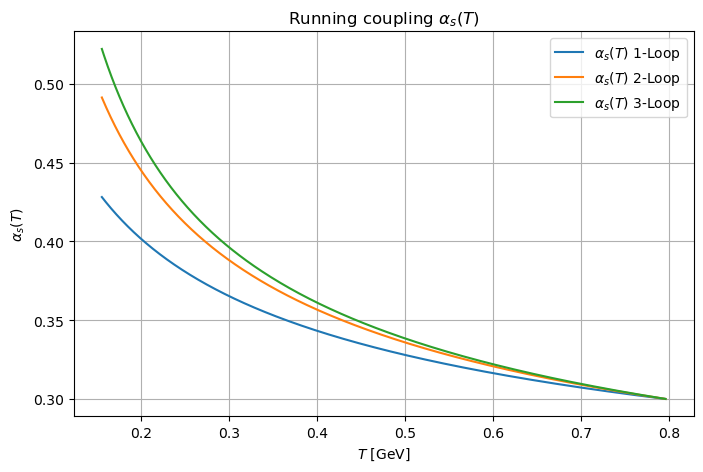

In [52]:
##### Integrating QCD beta funciton numerically

def BetaF1(mu, aS):
    return -B0*np.power(aS,2) 
def BetaF2(mu, aS):
    return -B0*np.power(aS,2) - B1*np.power(aS,3) 
def BetaF3(mu, aS):
    return -B0*np.power(aS,2) - B1*np.power(aS,3) - B2*np.power(aS,4)

alpha_0 = 0.3  # Initial value of alpha_s at mu0
mu0 = 5  # Reference scale in GeV

mu_range = np.logspace(np.log10(2*np.pi*0.155), np.log10(mu_0), 500)[::-1] # T=0.155GeV to mu=5GeV 

sol1 = solve_ivp(
    BetaF1,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)
sol2 = solve_ivp(
    BetaF2,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)
sol3 = solve_ivp(
    BetaF3,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)

# Extract the solution
alpha_s1 = sol1.y[0]
alpha_s2 = sol2.y[0]
alpha_s3 = sol3.y[0]

# Plot the running coupling
plt.figure(figsize=(8, 5))
plt.plot(mu_range/(2*np.pi), alpha_s1, label=r'$\alpha_s(T)$'+' 1-Loop')
plt.plot(mu_range/(2*np.pi), alpha_s2, label=r'$\alpha_s(T)$'+' 2-Loop')
plt.plot(mu_range/(2*np.pi), alpha_s3, label=r'$\alpha_s(T)$'+' 3-Loop')
#plt.xscale('log')
plt.xlabel(r'$T$ [GeV]')
plt.ylabel(r'$\alpha_s(T)$')
plt.title('Running coupling '+r'$\alpha_s(T)$')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
mu_range[0]/(2*np.pi)

0.15915494309189535

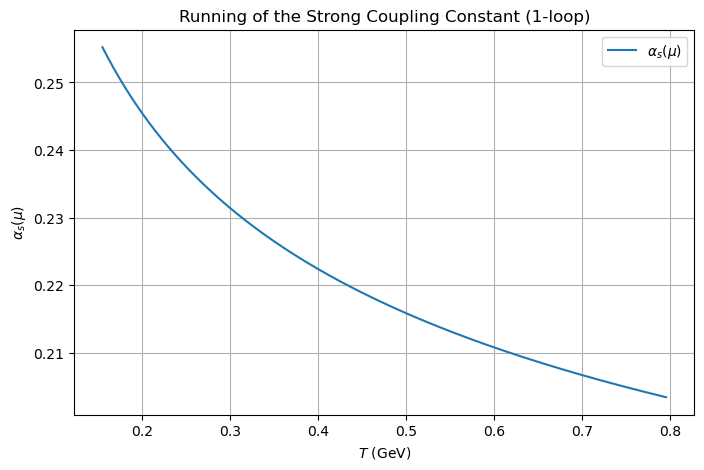

In [50]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
Nc = 3  # Number of colors
Nf = 5  # Number of active quark flavors
B0 = (11 * Nc - 2 * Nf) / (12 * np.pi)  # 1-loop beta coefficient

# Define the beta function as a differential equation
def beta(mu, alpha):
    return -B0 * alpha**2

# Initial condition (at a reference scale)
alpha_0 = 0.2034 # Initial value of alpha_s at mu0
mu0 = 5  # Reference scale in GeV

# Integration range (logarithmic scale)
mu_range = np.logspace(np.log10(2*np.pi*0.155), np.log10(mu_0), 500)[::-1]  # from 1 GeV to 1000 GeV

# Solve the differential equation
sol = solve_ivp(
    beta,  # Function to integrate
    [np.log(mu_range[0]), np.log(mu_range[-1])],  # Integration bounds in log(mu)
    [alpha_0],  # Initial condition
    t_eval=np.log(mu_range)  # Points to evaluate the solution
)

# Extract the solution
alpha_s = sol.y[0]

# Plot the running coupling
plt.figure(figsize=(8, 5))
plt.plot(mu_range/(2*np.pi), alpha_s, label=r'$\alpha_s(\mu)$')
#plt.xscale('log')
plt.xlabel(r'$T$ (GeV)')
plt.ylabel(r'$\alpha_s(\mu)$')
plt.title('Running of the Strong Coupling Constant (1-loop)')
plt.legend()
plt.grid(True)
plt.show()


